## Proyecto Procesamiento de Hidrógeno – ICTC 1D (Tubo–Carcasa)

## Resumen técnico y objetivos del modelo:

Este proyecto modela un intercambiador de calor tipo tubo–carcasa (ICTC)
aplicado al procesamiento de hidrógeno, donde el objetivo principal es
simular el proceso de evaporación y sobrecalentamiento de agua empleando
una mezcla eutéctica de **sales solares (NaNO₃/KNO₃)** como fluido caliente.
El modelo se desarrolla bajo un esquema unidimensional (1D), considerando
tres zonas térmicas diferenciadas a lo largo del tubo:
(I) agua líquida, (II) ebullición con cambio de fase y (III) vapor sobrecalentado.

Las correlaciones de transferencia de calor empleadas fueron:
Lado carcasa: correlación de Kern.
Lado tubo (monofásico): correlación de Gnielinski.
Lado tubo (ebullición): correlación de Gungor–Winterton (1987).

Los parámetros geométricos del haz de tubos se obtuvieron de Incropera
(1" OD, 1.25" pitch, 1-P). El régimen de operación es a contracorriente.

1. Importación de librerías

In [15]:
import math
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


2. Parámetros de diseño y constantes

In [16]:
INCH = 0.0254
g = 9.81

# -----------------------------
# Tabla Incropera (1" OD, 1.25" square pitch, 1-P)
# -----------------------------
INCROP_1IN_125P_1P = {
     8:  21, 10:  32, 12:  48, 13.5: 61, 15.5: 81, 17.5:112, 19.5:138,
    21.5:177, 23.5:213, 25: 260, 27: 300, 29: 341, 31: 406, 33: 465,
    35: 522, 37: 596, 39: 685
}

3. Clases de datos y definición de estructuras

In [17]:
@dataclass
class Geometry:
    L: float
    Di: float
    Do: float
    Ds: float
    pitch: float
    B: float
    baffle_cut: float
    t_wall: float = 0.002
    k_wall: float = 16.0
    @property
    def P_inner(self) -> float:
        return math.pi * self.Di
    @property
    def R_wall(self) -> float:
        return self.t_wall / self.k_wall

@dataclass
class Operating:
    mdot_c_total: float
    mdot_h: float
    Tcin: float
    Thin: float
    Tsat: float
    h_fg: float = None

@dataclass
class Fouling:
    Rf_i: float = 1e-4
    Rf_o: float = 1e-4

4. Configuración inicial (editable)

In [18]:
# === EDITAR AQUÍ: tamaño del haz y caudales ===
SHELL_ID_IN = 31                            # 25, 27, 29, 31, 33...
N_TUBES     = INCROP_1IN_125P_1P[SHELL_ID_IN]

geom = Geometry(
    L=2.5,
    Do=1.0*INCH,                             # 1" OD
    Di=0.021,                                # ajusta si se tiene schedule
    Ds=SHELL_ID_IN*INCH,
    pitch=1.25*INCH,
    B=0.50*(SHELL_ID_IN*INCH),               # B/Ds (aquí 0.50, ajusta si se necesita)
    baffle_cut=0.25                          # 25%
)

op = Operating(
    mdot_c_total=1.2,                        # flujo total agua
    mdot_h=7.0,                              # flujo sal
    Tcin=25.0,
    Thin=550.0,
    Tsat=100.0
)

def h_fg_J_per_kg(Tsat_C: float) -> float:
    return 2.257e6
if op.h_fg is None:
    op.h_fg = h_fg_J_per_kg(op.Tsat)

# Ensuciamiento (se puede ajustar)
foul = Fouling(Rf_i=1.7e-4, Rf_o=1.0e-4)

5. Propiedades termofísicas (simplificadas)

In [19]:
# -----------------------------
# Propiedades (simplificadas)
# -----------------------------
def rho_salt(T):  return 2090.0 - 0.636*T
def mu_salt(T):   return (22.714 - 0.120*T + 2.281e-4*T**2 - 1.474e-7*T**3)*1e-3
def cp_salt(T):   return 1500.0
def k_salt(T):    return 0.45

def cp_w_liq(T):  return 4180.0
def cp_w_vap(T):  return 2010.0
def mu_w_liq(T):  return 2.8e-4
def k_w_liq(T):   return 0.68
def mu_w_vap(T):  return 1.3e-5
def k_w_vap(T):   return 0.03
def rho_w_liq(T): return 960.0
def rho_w_vap(T): return 5.0
def sigma_w(T):   return 0.059  # N/m aprox. cerca de 100–120 °C


6. Correlaciones de transferencia de calor (Kern, Gnielinski)

In [20]:
# -----------------------------
# 3) Kern sin As/De dados (arreglo cuadrado)
# -----------------------------
def De_shell_square(pitch, d_o):
    return max(1e-4, (4.0*pitch*pitch)/(math.pi*d_o) - d_o)

def As_shell_kern(Ds, B, b_cut, pitch, d_o):
    phi_free = max(0.05, 1.0 - (d_o/pitch)**2)
    return Ds * B * (1.0 - b_cut) * phi_free

As_shell = As_shell_kern(geom.Ds, geom.B, geom.baffle_cut, geom.pitch, geom.Do)
De_shell = De_shell_square(geom.pitch, geom.Do)

# -----------------------------
# 4) Correlaciones monofásicas
# -----------------------------
def Nu_gnielinski(Re, Pr):
    if Re <= 2300.0: return 4.36
    f = (0.79*math.log(Re) - 1.64)**-2
    return ((f/8.0)*(Re-1000.0)*Pr)/(1.0 + 12.7*(f/8.0)**0.5*(Pr**(2.0/3.0)-1.0))

def hi_gnielinski(mdot_per_tube, Di, rho, mu, k, cp):
    Ai = math.pi*Di**2/4.0
    u  = mdot_per_tube/(rho*Ai)
    Re = rho*u*Di/mu
    Pr = cp*mu/k
    Nu = Nu_gnielinski(Re, Pr)
    h  = Nu*k/Di
    return h, Re

def ho_kern(mdot_shell, De, As, rho, mu, k, cp):
    u  = mdot_shell/(rho*As)
    Re = rho*u*De/mu
    Pr = cp*mu/k
    Nu = 0.36*(Re**0.55)*(Pr**(1.0/3.0))
    h  = Nu*k/De
    return h, Re

# Shell (propiedades a T representativa)
T_salt_rep = 400.0
ho, Re_s = ho_kern(op.mdot_h, De_shell, As_shell,
                   rho_salt(T_salt_rep), mu_salt(T_salt_rep),
                   k_salt(T_salt_rep),  cp_salt(T_salt_rep))

# Inside por tubo (monofásico)
mdot_tube = op.mdot_c_total / N_TUBES
hi_liq, Re_liq = hi_gnielinski(mdot_tube, geom.Di, rho_w_liq(100.0), mu_w_liq(100.0), k_w_liq(100.0), cp_w_liq(100.0))
hi_vap, Re_vap = hi_gnielinski(mdot_tube, geom.Di, rho_w_vap(200.0),  mu_w_vap(200.0),  k_w_vap(200.0),  cp_w_vap(200.0))

7. Correlación de ebullición: Gungor–Winterton (1987)

In [21]:
# -----------------------------
# Ebullición interna – Gungor–Winterton (1987)
# -----------------------------
def hi_boil_gw(Th, Tsat, x, mdot_tube, Di):
    rho_l = rho_w_liq(Tsat); mu_l = mu_w_liq(Tsat); k_l = k_w_liq(Tsat); cp_l = cp_w_liq(Tsat)
    rho_v = rho_w_vap(Tsat+5.0); mu_v = mu_w_vap(Tsat+5.0)
    Ai = math.pi*Di**2/4.0
    G  = mdot_tube / Ai
    Re_lo = max(1.0, G*max(1e-6,1.0-x)*Di/mu_l)
    Pr_l  = cp_l*mu_l/k_l
    h_lo  = 0.023 * (Re_lo**0.8) * (Pr_l**0.4) * k_l / Di
    Rtot_pred = (1.0/h_lo) + geom.R_wall + (1.0/ho) + foul.Rf_i + foul.Rf_o
    U_pred    = 1.0 / Rtot_pred
    deltaT    = max(0.1, Th - Tsat)
    q_pp      = U_pred * deltaT
    Bo = max(1e-8, q_pp / (G * op.h_fg))
    if x <= 0.0:
        Co = 1e6
    else:
        Co = ((1.0 - x)/x)**0.8 * (rho_v/rho_l)**0.5 * (mu_l/mu_v)**0.1
    E = 1.0 + 3000.0*(Bo**0.86) + 1.12*(Co**(-0.75))
    h_tp = h_lo * E
    return float(min(max(h_tp, 4000.0), 60000.0))

def U_from(hi):
    Rtot = (1/hi) + geom.R_wall + (1/ho) + foul.Rf_i + foul.Rf_o
    return 1.0/Rtot

U_liq  = U_from(hi_liq)
U_vap  = U_from(hi_vap)

# Perímetro total del haz
P_bundle = N_TUBES * geom.P_inner

8. Ecuaciones 1D – contracorriente (Θ_h(x)=T_h(L-x))

En este apartado se plantean los balances diferenciales de energía para
cada zona del intercambiador. El sistema de EDOs se resuelve mediante el
método de Runge–Kutta de cuarto orden (RK4), el cual evalúa cuatro puntos
intermedios dentro de cada paso de integración para aproximar el valor de
la variable dependiente, asegurando estabilidad numérica y buena precisión
incluso con tamaños de paso relativamente grandes (dx = 0.003 m).

In [22]:
def rhs_liquid(x, y):
    Tc, Th = y
    qprime = U_liq * P_bundle * (Th - Tc)
    dTc = qprime / (op.mdot_c_total * cp_w_liq(Tc))
    dTh = -qprime / (op.mdot_h * cp_salt(Th))
    return np.array([dTc, dTh])

def rhs_boil(x, y):
    xv, Th = y  # Tc ≡ Tsat
    hi_loc = hi_boil_gw(Th, op.Tsat, max(0.0, min(0.999, xv)), mdot_tube, geom.Di)
    U_loc  = U_from(hi_loc)
    qprime = U_loc * P_bundle * (Th - op.Tsat)
    dxv = qprime / (op.mdot_c_total * op.h_fg)
    dTh = -qprime / (op.mdot_h * cp_salt(Th))
    return np.array([dxv, dTh])

def rhs_vapor(x, y):
    Tc, Th = y
    qprime = U_vap * P_bundle * (Th - Tc)
    dTc = qprime / (op.mdot_c_total * cp_w_vap(Tc))
    dTh = -qprime / (op.mdot_h * cp_salt(Th))
    return np.array([dTc, dTh])



9. Integrador numérico – Método de Runge–Kutta de 4° orden

El método RK4 estima la solución de una EDO avanzando un paso dx, combinando
cuatro evaluaciones sucesivas de la derivada: k1, k2, k3 y k4, ponderadas
para mejorar la precisión. La forma general es:
y_{i+1} = y_i + (dx/6)*(k1 + 2*k2 + 2*k3 + k4)
donde cada k_j representa la pendiente local en puntos intermedios dentro
del intervalo de integración. Este esquema balancea precisión y costo
computacional, siendo adecuado para sistemas acoplados Tc(x) y Th(x).

In [23]:
def rk4_step(fun, x, y, dx):
    k1 = fun(x, y)
    k2 = fun(x+0.5*dx, y+0.5*dx*k1)
    k3 = fun(x+0.5*dx, y+0.5*dx*k2)
    k4 = fun(x+dx,   y+dx*k3)
    return y + (dx/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def integrate(fun, x0, y0, dx, x_end, event=None):
    xs=[x0]; ys=[y0.copy()]
    x=x0; y=y0.copy()
    while (x+dx) <= x_end + 1e-12:
        y = rk4_step(fun, x, y, dx)
        x = x + dx
        xs.append(x); ys.append(y.copy())
        if event is not None and event(x, y): break
    return np.array(xs), np.vstack(ys)

10. Simulación de zonas (líquido, ebullición, vapor)

In [24]:
# Condiciones de borde (contracorriente mapeado)
dx = 0.003
y0_liq = np.array([op.Tcin, op.Thin])

# Zona I: líquido
xs1, ys1 = integrate(rhs_liquid, 0.0, y0_liq, dx, geom.L, event=lambda x,y: (y[0] >= op.Tsat))
x1 = xs1[-1]; Tc1, Th1 = ys1[-1]

# Zonas II y III
if Tc1 < op.Tsat - 1e-6 and x1 >= geom.L:
    xs2 = np.array([]); ys2 = np.empty((0,2))
    xs3 = np.array([]); ys3 = np.empty((0,2))
    Tc_out = Tc1; Th_out = Th1
else:
    xs2, ys2 = integrate(rhs_boil, x1, np.array([0.0, Th1]), dx, geom.L, event=lambda x,y: (y[0] >= 1.0))
    if ys2.size and ys2[-1,0] >= 1.0 and xs2[-1] < geom.L - 1e-9:
        xs3, ys3 = integrate(rhs_vapor, xs2[-1], np.array([op.Tsat, ys2[-1,1]]), dx, geom.L)
        Tc_out, Th_out = ys3[-1]
    else:
        xs3 = np.array([]); ys3 = np.empty((0,2))
        Tc_out = op.Tsat; Th_out = ys2[-1,1] if ys2.size else Th1


11. Post-procesamiento y visualización

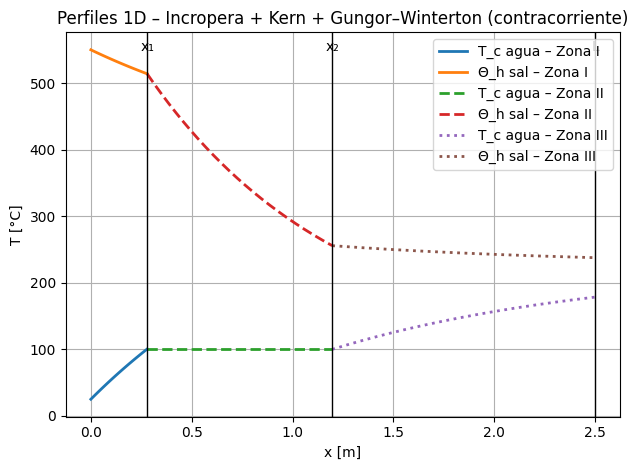

========== HAZ DE TUBOS ==========
Shell ID = 31 in  |  N_tubes = 406
Ds = 0.787 m,  pitch = 1.25 in,  B/Ds = 0.50, cut = 0.25
mdot agua total = 1.200 kg/s  (por tubo = 0.00296)
As_shell ≈ 0.08370 m² ; De_shell ≈ 0.0251 m ; Re_shell ≈ 1183
ho ≈ 571 W/m²K | hi_liq ≈ 141 W/m²K | hi_vap ≈ 61 W/m²K

Transiciones:
x1 = 0.279 m  (Tc→Tsat=100.0 °C)
x2 = 1.197 m  (x_v fin zona II = 1.001)
L  = 2.500 m
Zona III (sobrecalentado): de x=1.197 m a L=2.500 m

Salidas:
Tc_out = 178.4 °C ; Θh_out = 237.7 °C

CSV: perfiles_1D_incropera_kern_GW.csv


In [28]:
# -----------------------------
# Resultados y gráficos (segmentados + marcas x1, x2, L)
# -----------------------------
rec=[]
for x,(Tc,Th) in zip(xs1,ys1): rec.append({"x_m":x,"zone":"I (líq.)","T_c":Tc,"Theta_h":Th,"xv":0.0})
for x,(xv,Th) in zip(xs2,ys2): rec.append({"x_m":x,"zone":"II (ebul.)","T_c":op.Tsat,"Theta_h":Th,"xv":xv})
for x,(Tc,Th) in zip(xs3,ys3): rec.append({"x_m":x,"zone":"III (vap.)","T_c":Tc,"Theta_h":Th,"xv":1.0})
df = pd.DataFrame(rec)

# --- gráfico segmentado ---
plt.figure()
# ZONA I
m1 = df["zone"]=="I (líq.)"
plt.plot(df.loc[m1,"x_m"], df.loc[m1,"T_c"],  label="T_c agua – Zona I",  linewidth=2)
plt.plot(df.loc[m1,"x_m"], df.loc[m1,"Theta_h"], label="Θ_h sal – Zona I", linewidth=2)
# ZONA II
m2 = df["zone"]=="II (ebul.)"
if m2.any():
    plt.plot(df.loc[m2,"x_m"], df.loc[m2,"T_c"],  label="T_c agua – Zona II",  linestyle="--", linewidth=2)
    plt.plot(df.loc[m2,"x_m"], df.loc[m2,"Theta_h"], label="Θ_h sal – Zona II", linestyle="--", linewidth=2)
# ZONA III
m3 = df["zone"]=="III (vap.)"
if m3.any():
    plt.plot(df.loc[m3,"x_m"], df.loc[m3,"T_c"],  label="T_c agua – Zona III",  linestyle=":", linewidth=2)
    plt.plot(df.loc[m3,"x_m"], df.loc[m3,"Theta_h"], label="Θ_h sal – Zona III", linestyle=":", linewidth=2)

# Marcas x1, x2 y L
plt.axvline(x1, color='k', linewidth=1)
plt.text(x1, plt.gca().get_ylim()[1]*0.98, "x₁", ha="center", va="top")
if m2.any():
    x2 = df.loc[m2, "x_m"].iloc[-1]
    plt.axvline(x2, color='k', linewidth=1)
    plt.text(x2, plt.gca().get_ylim()[1]*0.98, "x₂", ha="center", va="top")
plt.axvline(geom.L, color='k', linewidth=1)
plt.text(geom.L, plt.gca().get_ylim()[1]*0.98, "L", ha="center", va="top")

plt.xlabel("x [m]"); plt.ylabel("T [°C]")
plt.title("Perfiles 1D – Incropera + Kern + Gungor–Winterton (contracorriente)")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# Resumen
print("========== HAZ DE TUBOS ==========")
print(f"Shell ID = {SHELL_ID_IN} in  |  N_tubes = {N_TUBES}")
print(f"Ds = {geom.Ds:.3f} m,  pitch = {geom.pitch/INCH:.2f} in,  B/Ds = {geom.B/geom.Ds:.2f}, cut = {geom.baffle_cut:.2f}")
print(f"mdot agua total = {op.mdot_c_total:.3f} kg/s  (por tubo = {(op.mdot_c_total/N_TUBES):.5f})")
print(f"As_shell ≈ {As_shell:.5f} m² ; De_shell ≈ {De_shell:.4f} m ; Re_shell ≈ {ho_kern(op.mdot_h,De_shell,As_shell,rho_salt(400),mu_salt(400),k_salt(400),cp_salt(400))[1]:.0f}")
print(f"ho ≈ {ho:.0f} W/m²K | hi_liq ≈ {hi_liq:.0f} W/m²K | hi_vap ≈ {hi_vap:.0f} W/m²K")
print("\nTransiciones:")
print(f"x1 = {x1:.3f} m  (Tc→Tsat={op.Tsat} °C)")
if m2.any():
    x2 = df.loc[m2, "x_m"].iloc[-1]
    print(f"x2 = {x2:.3f} m  (x_v fin zona II = {df.loc[m2,'xv'].iloc[-1]:.3f})")
print(f"L  = {geom.L:.3f} m")
if m3.any():
    print(f"Zona III (sobrecalentado): de x={df.loc[m2,'x_m'].iloc[-1]:.3f} m a L={geom.L:.3f} m")
else:
    print("Sin Zona III dentro de L (ebullición incompleta).")

print("\nSalidas:")
print(f"Tc_out = {df.iloc[-1]['T_c']:.1f} °C ; Θh_out = {df.iloc[-1]['Theta_h']:.1f} °C")

# CSV para post-proceso
df.to_csv("perfiles_1D_incropera_kern_GW.csv", index=False)
print("\nCSV: perfiles_1D_incropera_kern_GW.csv")


## Análisis de Resultados – ICTC 1D (Tubo–Carcasa, Contracorriente)

El gráfico obtenido representa los **perfiles de temperatura** de los fluidos caliente (sal solar) y frío (agua) a lo largo del intercambiador de calor. El modelo considera **flujo a contracorriente** y tres zonas térmicas: (I) líquida, (II) ebullición y (III) vapor sobrecalentado.

### **Zona I – Agua líquida (0 < x < x₁ ≈ 0.3 m)**
- El agua se calienta desde su temperatura de entrada (~25 °C) hasta alcanzar la temperatura de saturación (~100 °C).
- La sal solar, a ~550 °C, experimenta una caída de temperatura moderada.
- El intercambio de calor es intenso por la alta diferencia de temperaturas y el coeficiente de convección elevado del agua líquida.
- El flujo en la carcasa (según Kern) se mantiene en régimen **turbulento** (Re > 1000).

### **Zona II – Ebullición (x₁ < x < x₂ ≈ 1.2 m)**
- La temperatura del agua permanece constante (≈100 °C) mientras ocurre el **cambio de fase**.
- La pendiente de la curva de la sal se vuelve más pronunciada: la mayor parte del calor se utiliza en el cambio de fase.
- La correlación de **Gungor–Winterton (1987)** refleja el aumento local de la transferencia de calor por ebullición nucleada y convectiva.

### **Zona III – Vapor sobrecalentado (x > x₂)**
- El vapor de agua comienza a **elevar su temperatura por encima del punto de saturación**, alcanzando ~180 °C.
- El coeficiente de convección disminuye por la menor densidad y conductividad térmica del vapor, lo que explica la pendiente más suave.
- La sal solar se estabiliza alrededor de 230–240 °C, lo que indica que la potencia térmica disponible no se agota totalmente.

### **Balance térmico global**
| Parámetro | Valor aproximado |
|------------|------------------|
| Tₕ,in (sal solar) | 550 °C |
| Tₕ,out (sal solar) | 240 °C |
| T꜀,in (agua) | 25 °C |
| T꜀,out (agua) | 180 °C |
| ΔTₗₘ (logarítmica media) | ≈ 250–270 °C |


El **salto térmico total en la sal (~310 °C)** es suficiente para cubrir tanto la etapa de calentamiento como la de evaporación y sobrecalentamiento.

### **Comportamiento físico y validación numérica**
- Las curvas son **continuas**, confirmando una correcta implementación del método **Runge–Kutta 4° orden (RK4)**.
- El perfil plano de temperatura durante la ebullición valida la condición **T꜀ = Tsat**.
- No se observan discontinuidades ni divergencias, lo que evidencia **convergencia estable** y un adecuado tamaño de paso (dx = 0.003 m).

### **Conclusión técnica**
- El ICTC 1D presenta un **comportamiento térmico coherente con la teoría** y buen desempeño numérico.
- El agua se calienta, evapora y sobrecalienta progresivamente; la sal entrega calor de manera sostenida.
- El método RK4 permite una integración estable y precisa de las EDOs.
- El diseño actual logra completar la evaporación con un sobrecalentamiento moderado; un mayor **flujo de sal o longitud del haz** podría aumentar la eficiencia térmica.
